# M2 and S2 tidal height model

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

sns.set()
sns.set_style("dark")
# sns.set_palette("dark")

## make a new TidalHeightComp class

In [2]:
class TidalHeightComp:
    def __init__(self, name, period, height):
        self.name = name
        self.period = period
        self.height = height
        # break into symmetrical clockwise and anticlockwise rotating components, each with half amplitude
        self.ccw_comp = (self.height[0]/2.0,self.height[1])
        self.cw_comp = (self.height[0]/2.0,-self.height[1])
        self.rotate = ["CCW","CW"]
        
    def get_name(self):
        return self.name
    def get_period(self):
        return self.period
    def get_height(self,rotate):
        return self.height

    def timeseries(self,t):
        return xr.DataArray([self.ccw_comp[0]*np.exp(1j*self.ccw_comp[1])*np.exp(1j*2.0*np.pi*(t/self.period))
                             ,self.cw_comp[0]*np.exp(1j*self.cw_comp[1])*np.exp(1j*2.0*np.pi*(-t/self.period))]
                            ,coords=[("rotate",self.rotate),("time",t)]
                            ,dims=["rotate","time"])
        
class ComponentSet:
    def __init__(self):
        self.tides = {}
        
    def add_tide(self,tide):
        self.tides[tide.get_name()]=tide
    
    def list_tides(self):
        return self.tides.keys()
    def tide(self,name):
        return self.tides[name]
        
    

### build set of tidal components

In [3]:
tides = ComponentSet()
tides.add_tide(TidalHeightComp('M2',12.42060120,(1.09,1.0*np.pi)))
tides.add_tide(TidalHeightComp('S2',12.00000000,(0.47,(1.0/3.0)*np.pi)))
tides.add_tide(TidalHeightComp('N2',12.65834751,(0.23,(1.0/4.0)*np.pi)))
tides.add_tide(TidalHeightComp('O1',25.81933871,(0.10,1.66*np.pi)))
tides.add_tide(TidalHeightComp('K1',23.93447213,(0.05,0.75*np.pi)))


### array of times, in hours, to calculate currents at

In [4]:
# dimensions, times for calculation
t = np.arange(0, 1000.0, 0.5)

### choose which components to plot - order of selection matters

In [5]:
# build xarray DataSet of tidal timeseries to plot - use all or specify a subset
td = xr.Dataset()
# for comp in tides.list_tides():
for comp in ['M2','S2','N2','K1','O1']:
    tide = tides.tide(comp)
    td = td.assign({comp:tide.timeseries(t)}) 

### plot and animate

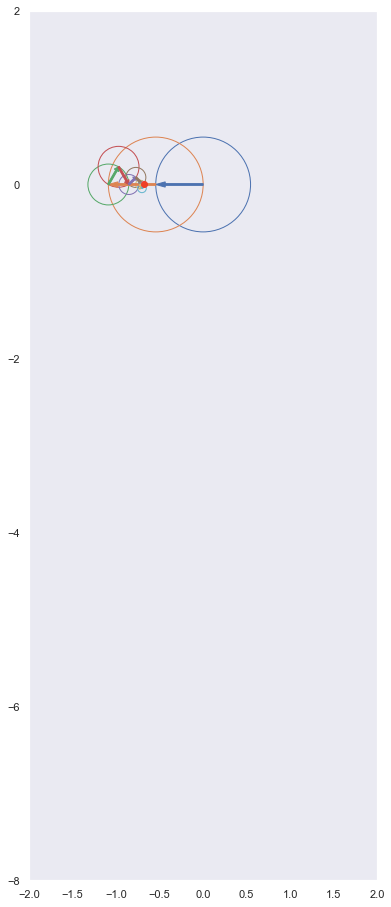

In [6]:
fig,ax = plt.subplots(figsize=(8,16))

i = 0
scale = 0.1
origin = 0 + 1j*0
new_origin = 0 + 1j*0

patches_c = []
patches_a = []

# component arrows and circles
ii=0
for varname, da in td.data_vars.items():
    patches_c.append(plt.Circle((new_origin.real,new_origin.imag),np.abs(da.sel(rotate="CCW").data[0]),fill=False,color='C'+str(ii),lw=1.0))
    patches_a.append(plt.Arrow(new_origin.real,new_origin.imag,da.sel(rotate="CCW").data[i].real,da.sel(rotate="CCW").data[i].imag,
                      width=1.0*scale,color='C'+str(ii)))
    new_origin = new_origin + da.sel(rotate="CCW").data[i]
    ii += 1
    patches_c.append(plt.Circle((new_origin.real,new_origin.imag),np.abs(da.sel(rotate="CW").data[0]),fill=False,color='C'+str(ii),lw=1.0))
    patches_a.append(plt.Arrow(new_origin.real,new_origin.imag,da.sel(rotate="CW").data[i].real,da.sel(rotate="CW").data[i].imag,
                      width=1.0*scale,color='C'+str(ii)))
    new_origin = new_origin + da.sel(rotate="CW").data[i]
    ii += 1
    
for patch in patches_c:
    ax.add_patch(patch)
for patch in patches_a:
    ax.add_patch(patch)

# total velocity tracking point
scat = ax.scatter(new_origin.real,new_origin.imag,color='xkcd:tomato',zorder=10)

# total velocity ellipse trace
x = np.array([new_origin.real])
y = np.array([new_origin.imag])
line, = ax.plot(x,y,zorder=0,color='xkcd:black',alpha=0.5)

ax.set_aspect('equal')
ax.set_xlim(-2.0,2.0)
ax.set_ylim(-8,2.0)

def animate(i):
    global x,y,patches_a

# remove old arrows (arrows cannot be updated)
    for patch in patches_a:
        patch.remove()
    patches_a = []

# loop over all tidal components
    new_origin = 0 + 1j*0
    ii = 0
    for varname, da in td.data_vars.items():
        
        patches_c[ii].center = (new_origin.real,new_origin.imag)
        patches_a.append(plt.Arrow(new_origin.real,new_origin.imag,da.sel(rotate="CCW").data[i].real,da.sel(rotate="CCW").data[i].imag,
                          width=1.0*scale,color='C'+str(ii)))
        new_origin = new_origin + da.sel(rotate="CCW").data[i]
        ii += 1
        patches_c[ii].center = (new_origin.real,new_origin.imag)
        patches_a.append(plt.Arrow(new_origin.real,new_origin.imag,da.sel(rotate="CW").data[i].real,da.sel(rotate="CW").data[i].imag,
                          width=1.0*scale,color='C'+str(ii)))
        new_origin = new_origin + da.sel(rotate="CW").data[i]
        ii += 1

    for patch in patches_a:
        ax.add_patch(patch)

# total velocity tracking point
    scat.set_offsets(np.c_[new_origin.real,new_origin.imag])

    # total velocity ellipse trace
    x = np.append(x,new_origin.real)
    y = np.append((y-0.005),new_origin.imag)
    line.set_xdata(x)
    line.set_ydata(y)

    return scat,line

anim = FuncAnimation(
    fig, animate,frames = 1600,interval = 50)

In [7]:
HTML(anim.to_html5_video())